## Changing the number of channels

Can we still train a model with an increased number of channels in the context set? In this section we will load multiple variables from the ERA5 dataset, and attempt to use these to fine-tune the baseline model.

Additionally, we will not coarsen the ERA5 dataset, and crop to a smaller resolution.

It would be nice if additional channels are supported in the model. It could be useful to have multiple x1x2 channels at different resolutions, so that x1x2 channels can be shared (not re-learned) between experiments, but still would maintain a reasonable scale between experiments.

In [33]:
# setup project root for imports (requirement for all notebooks in this repo)
import sys
from pathlib import Path

# Make project root importable
ROOT = Path().resolve().parents[1]
sys.path.append(str(ROOT))

In [34]:
# setup logging (useful for running with nohup)
from src.config.logging_config import setup_logging
import logging

setup_logging()  # configure logging
logger = logging.getLogger(__name__)
logger.info("Notebook execution started.")

# setup tensorboard logging
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

TB_TRAIN_LOSS = "Loss/Train"
TB_VAL_LOSS = "Loss/Validation"
TB_EXPERIMENT = "exp2_transfer_learning"

TB_WRITE = False

tb_writer = SummaryWriter(log_dir=str(ROOT / ".tb_logs" / TB_EXPERIMENT / f"run_s1_{datetime.now().strftime('%d-%m %H:%M')}"))

2025-12-03 15:46:29 - INFO - __main__ - Notebook execution started.


In [35]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
%autoreload 2
from src.utils.variables.var_names import *
from src.utils.variables.coord_names import *
from src.data_processing.conversions.scalar_conversions import *
from src.config.env_loader import get_env_var
import src.learning.model_diagnostics as model_diagnostics
from src.learning.model_training import batch_data_by_num_stations, compute_val_loss

from src.data_processing.station_processor import ProcessStations
from src.data_processing.topography_processor import ProcessTopography
from src.data_processing.era5_processor import ProcessERA5

from src.data_processing.auxiliary.sun_position import get_sun_culmination, get_sun_position
from src.data_processing.auxiliary.positional_encodings import build_cropped_auxiliary

In [37]:
# DeepSensor imports
# note this pulls from a fork of DeepSensor.
import deepsensor.torch
from deepsensor.train.train import train_epoch, set_gpu_default_device, concat_tasks
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.data.utils import construct_x1x2_ds

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from mpl_toolkits.basemap import Basemap
import torch
from torch import optim
import os
import lab as B
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cf
import gc

In [38]:
# setup variables for experiment
years = [2010, 2011, 2012, 2013, 2014]

train_years = [2010, 2011, 2012, 2013]
validation_years = [2014]

# model hyperparameters
BATCH_SIZE = 32
N_EPOCH = 10
LR = 5e-5

# GPU settings
use_gpu = True
if use_gpu:
    cuda_device = int(get_env_var("CUDA_DEVICE"))
    set_gpu_default_device(backend="cuda", dev_id=cuda_device)

In [39]:
# dataset loader modules. These are from src.data_processing.
#    They use a file loader module in src.data_processing.file_loaders to load raw data files,
#    in the case of getting data in a different structure, changes will need to be made to the file loader modules.
station_processor = ProcessStations()
topography_processor = ProcessTopography()
era5_processor = ProcessERA5()

In [40]:
# save the model to OUTPUT_HOME/models/exp2_transfer_learning/baseline.pt
folder = os.path.join(get_env_var("OUTPUT_HOME"), "models", "exp2_transfer_learning", "baseline")

In [41]:
era5_ds = era5_processor.load_ds(mode="surface", years=years, standardise_var_names=True, standardise_coord_names=True)
era5_var = era5_processor.get_variable(era5_ds, TEMPERATURE) # set variable to process - e.g. "temperature"
era5_var = kelvin_to_celsius(era5_var)
era5_ds[TEMPERATURE] = era5_var

# add sun culmination context to the dataset
era5_ds[SUN_CULMINATION] = get_sun_culmination(era5_ds.coords)
era5_ds[SUN_ANGLE] = get_sun_position(era5_ds.coords)

# select wind_u and wind_v variables
era5_ds = era5_ds[[TEMPERATURE, SURFACE_PRESSURE, SUN_CULMINATION, SUN_ANGLE]]

era5_ds_coarsen = era5_ds

In [42]:
topography_ds = topography_processor.load_ds(standardise_var_names=True, standardise_coord_names=True)
ds_aux = topography_processor.compute_tpi(topography_ds, window_sizes=[0.1])

# use less-coarse auxiliary data
AUXILIARY_COARSEN_FACTOR = 100
ds_aux_coarse  = ds_aux.coarsen(
    lat=AUXILIARY_COARSEN_FACTOR, 
    lon=AUXILIARY_COARSEN_FACTOR, 
    boundary='trim').mean()

# FYI training loop fails if you don't do this
ds_aux = ds_aux.fillna(0)
ds_aux_coarse = ds_aux_coarse.fillna(0)

In [43]:
# build the station dataset (context & target set)

# load the stations with the variable of interest between the start and end years
stations_df = station_processor.load_df(vars=[TEMPERATURE], year_start=2010, year_end=2014)
stations_df.head()
stations_reset = stations_df.reset_index()
stations_reset.drop(columns=['station'], inplace=True)

# resample to six-hourly frequency to match ERA5 timestamps
stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[[TEMPERATURE]]
stations_resample = stations_resample.reset_index().set_index(['time', 'lat', 'lon']).sort_index()

# drop station gisborne aero aws (too close to other station)
drop_lat, drop_lon = -38.66100, 177.98600

stations_resample = stations_resample[~((stations_resample.index.get_level_values('lat') == drop_lat) 
                                        & (stations_resample.index.get_level_values('lon') == drop_lon))]

/home/crowelenn/niwa/convcnp-assim-nz/src/data_processing/station_processor.py:157: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  ds_comb = xr.concat([first, *station_iter], dim="station")
/tmp/ipykernel_294771/2551418850.py:10: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[[TEMPERATURE]]


In [44]:
# crop all datasets to a smaller area

crop_left = 166
crop_right = 176
crop_top = -38
crop_bottom = -48

era5_ds_cropped = era5_ds_coarsen.sel(lat=slice(crop_top, crop_bottom), lon=slice(crop_left, crop_right))
ds_aux_cropped = ds_aux.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))
ds_aux_coarse_cropped = ds_aux_coarse.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))
stations_resample = stations_resample[(stations_resample.index.get_level_values('lat') > crop_bottom) & (stations_resample.index.get_level_values('lat') < crop_top) &
                                      (stations_resample.index.get_level_values('lon') > crop_left) & (stations_resample.index.get_level_values('lon') < crop_right)]

In [45]:
data_processor_wide_area = DataProcessor(x1_name=LATITUDE, x1_map=(era5_ds[LATITUDE].min(), era5_ds[LATITUDE].max()), x2_name=LONGITUDE, x2_map=(era5_ds[LONGITUDE].min(), era5_ds[LONGITUDE].max()))
data_processor = DataProcessor(x1_name=LATITUDE, x1_map=(era5_ds_cropped[LATITUDE].min(), era5_ds_cropped[LATITUDE].max()), x2_name=LONGITUDE, x2_map=(era5_ds_cropped[LONGITUDE].min(), era5_ds_cropped[LONGITUDE].max()))

era5_processed, station_processed = data_processor([era5_ds_cropped, stations_resample])

ds_aux_processed_cropped, ds_aux_coarse_processed_cropped = data_processor([ds_aux_cropped, ds_aux_coarse_cropped], method='min_max')
ds_aux_processed, ds_aux_coarse_processed = data_processor_wide_area([ds_aux, ds_aux_coarse], method='min_max')
ds_aux_processed_merged = build_cropped_auxiliary(ds_aux, ds_aux_cropped, ds_aux_processed, ds_aux_processed_cropped)
ds_aux_coarse_processed_merged = build_cropped_auxiliary(ds_aux_coarse, ds_aux_coarse_cropped, ds_aux_coarse_processed, ds_aux_coarse_processed_cropped)

task_loader = TaskLoader(
        context = [station_processed, era5_processed, ds_aux_coarse_processed_merged], 
        target = station_processed, 
        aux_at_targets = ds_aux_processed_merged, 
        links = [(0, 0)])


/home/crowelenn/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"x1_map={x1_map} and x2_map={x2_map} have different ranges ({float(np.diff(x1_map))} "
/home/crowelenn/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"and {float(np.diff(x2_map))}, respectively). "
/home/crowelenn/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:128: UserWarning: x1_map=(-50.0, -32.0) and x2_map=(165.0, 180.0) have different ranges (18.0 and 15.0, respectively). This can lead to stretching

In [46]:
old_model = ConvNP(data_processor, task_loader, folder)
model = ConvNP(data_processor, task_loader, unet_channels=(64,)*5, likelihood="gnp")
model.model.decoder.links[0].before_turn_layers[1] = old_model.model.decoder.links[0].before_turn_layers[1] # reuse the old model's unet weights, except for the initial projection

dim_yc inferred from TaskLoader: (1, 4, 6)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 6
Setting aux_t_mlp_layers: (64, 64, 64)
internal_density inferred from TaskLoader: 78
encoder_scales inferred from TaskLoader: [0.00641025641025641, 0.012500000186264515, 0.006399991922080517]
decoder_scale inferred from TaskLoader: 0.01282051282051282


In [47]:
# free up memory
del old_model
gc.collect()

132620

In [48]:
task_loader.load_dask()

train_dates = era5_ds.sel(time=slice(f"{train_years[0]}-01-01", f"{train_years[-1]}-12-31")).time.values
val_dates = era5_ds.sel(time=slice(f"{validation_years[0]}-01-01", f"{validation_years[-1]}-12-31")).time.values

train_tasks = []
for date in train_dates:
    task = task_loader(date, context_sampling=["split", "all", "all"], target_sampling=["split"], split_frac=0.5)
    train_tasks.append(task)

val_tasks = []
for date in val_dates:
    task = task_loader(date, context_sampling=["split", "all", "all"], target_sampling=["split"], split_frac=0.5)
    val_tasks.append(task)

train_tasks_batched = batch_data_by_num_stations(train_tasks, batch_size=BATCH_SIZE)
validation_tasks_batched = batch_data_by_num_stations(val_tasks, batch_size=BATCH_SIZE)

# group the tasks into batches
train_tasks_epoch = [ concat_tasks(train_tasks_batched[f"{train_task_id}"]) for train_task_id in train_tasks_batched.keys()]
val_tasks_epoch = [ concat_tasks(validation_tasks_batched[f"{val_task_id}"]) for val_task_id in validation_tasks_batched.keys()]

In [49]:
logger.info("Section 2: Altering channels & coarsening: Training Started.")

2025-12-03 15:54:26 - INFO - __main__ - Section 2: Altering channels & coarsening: Training Started.


In [50]:
tb_writer = SummaryWriter(log_dir=str(ROOT / ".tb_logs" / TB_EXPERIMENT / f"run_s2_{datetime.now().strftime('%d-%m %H:%M')}"))

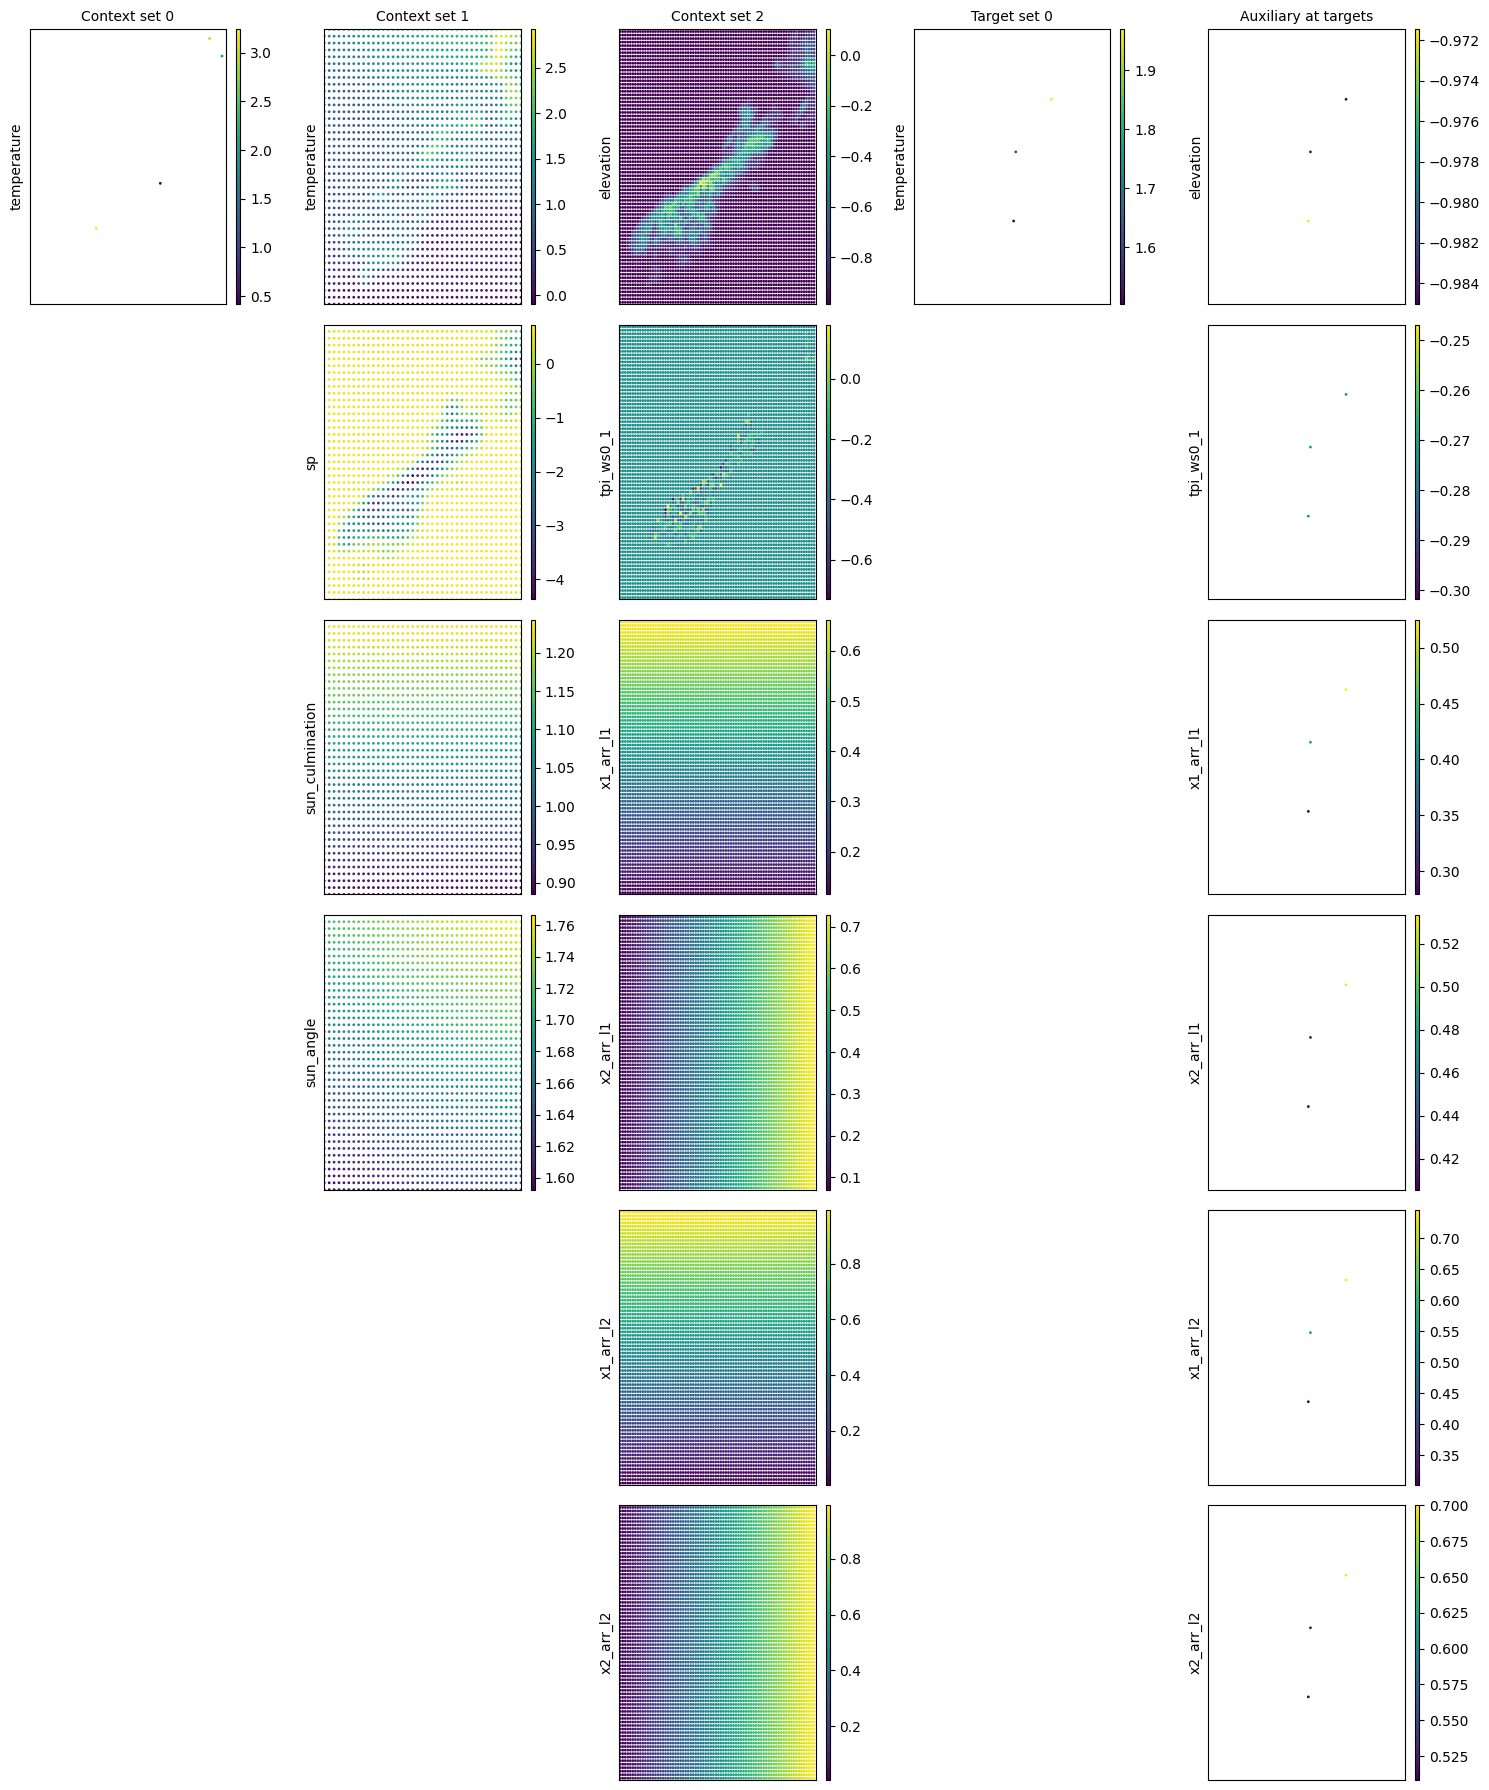

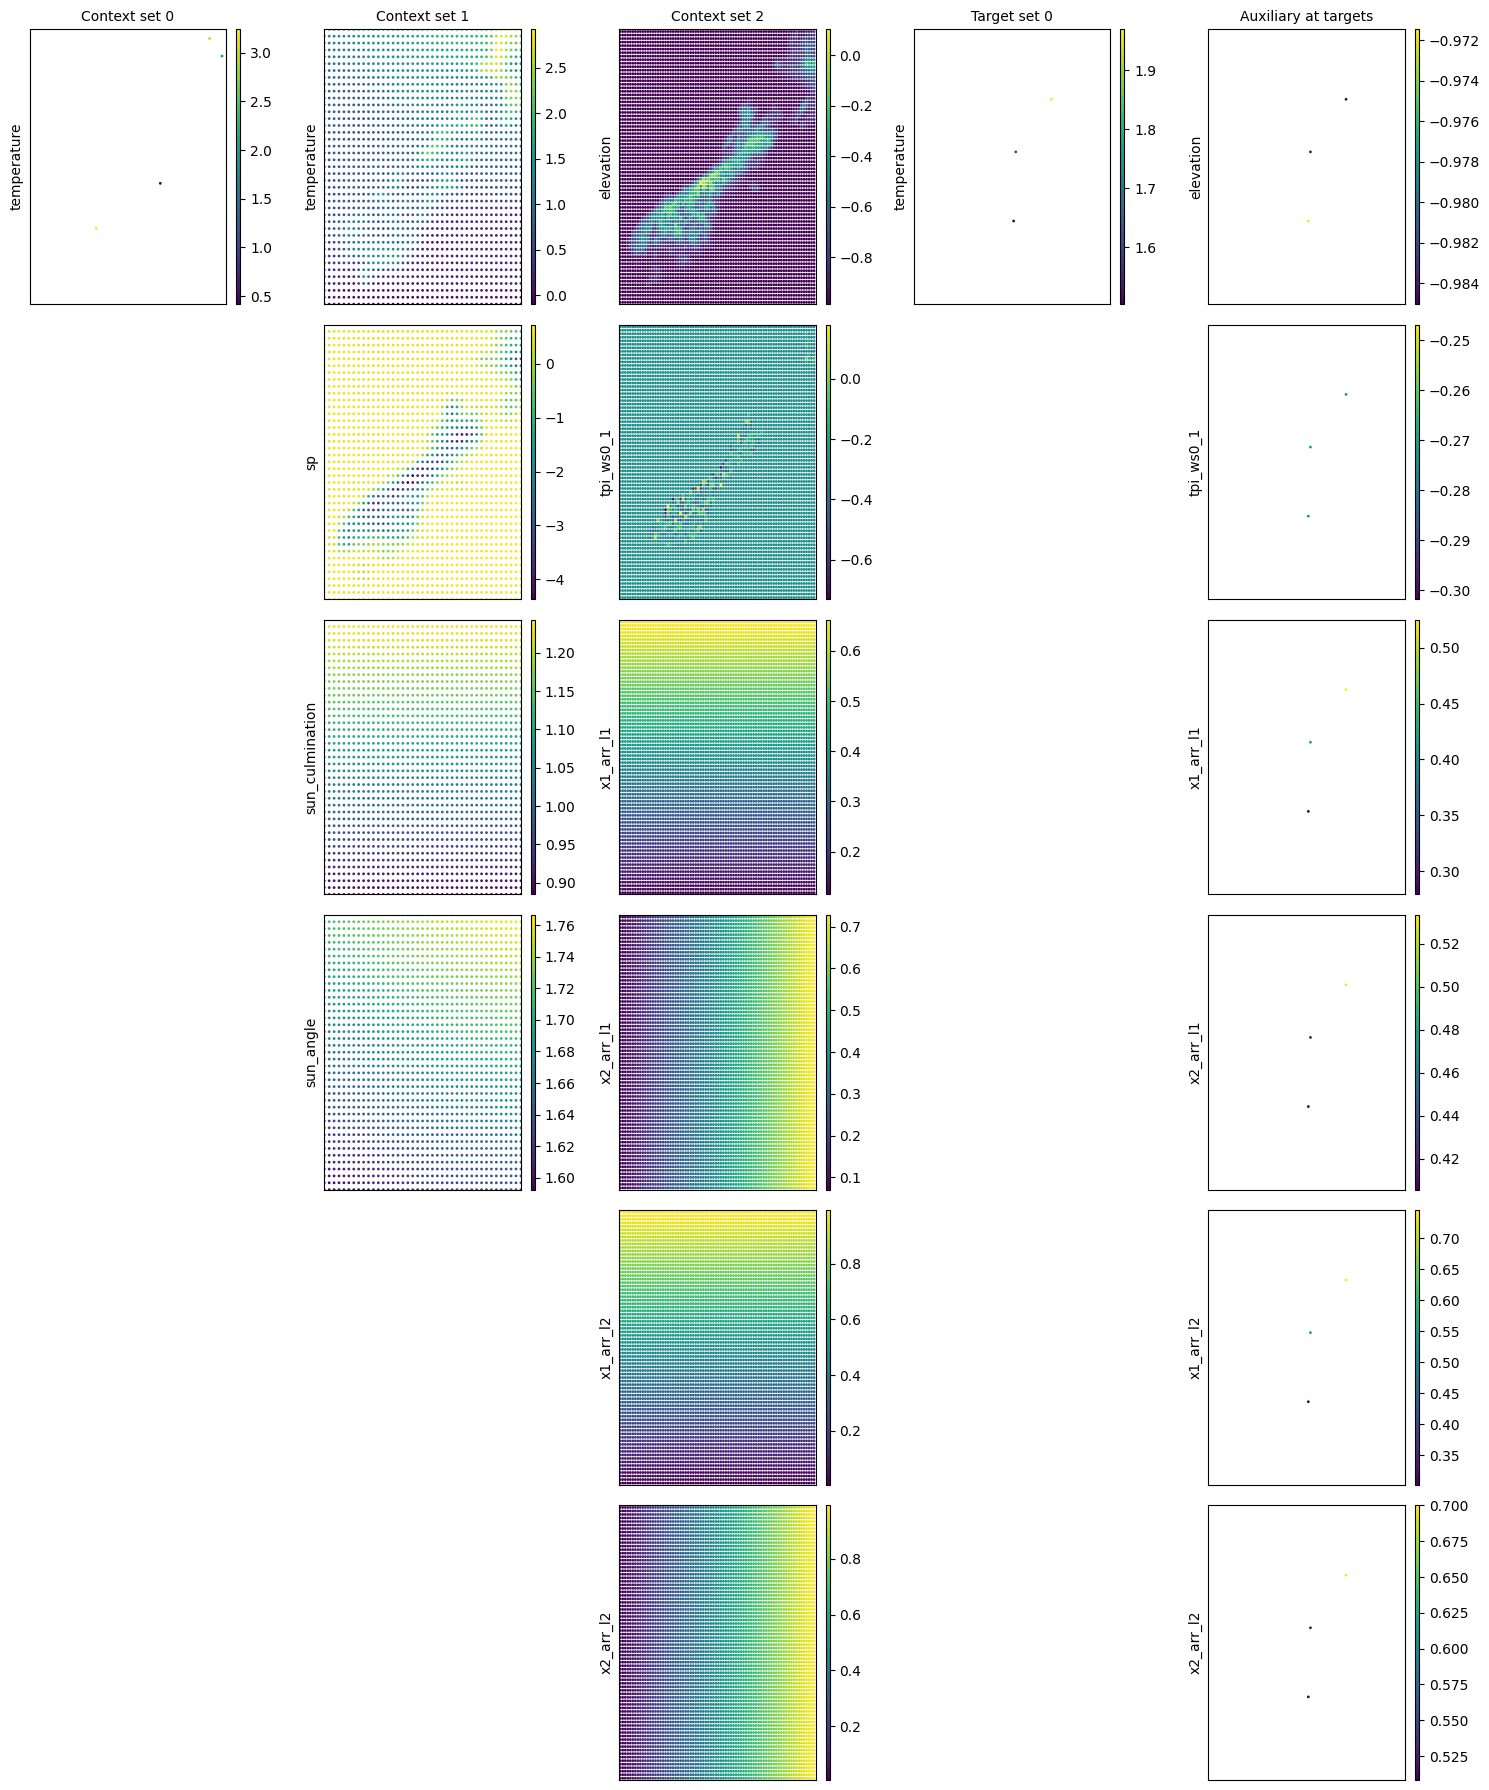

In [51]:
deepsensor.plot.task(train_tasks[100], task_loader)

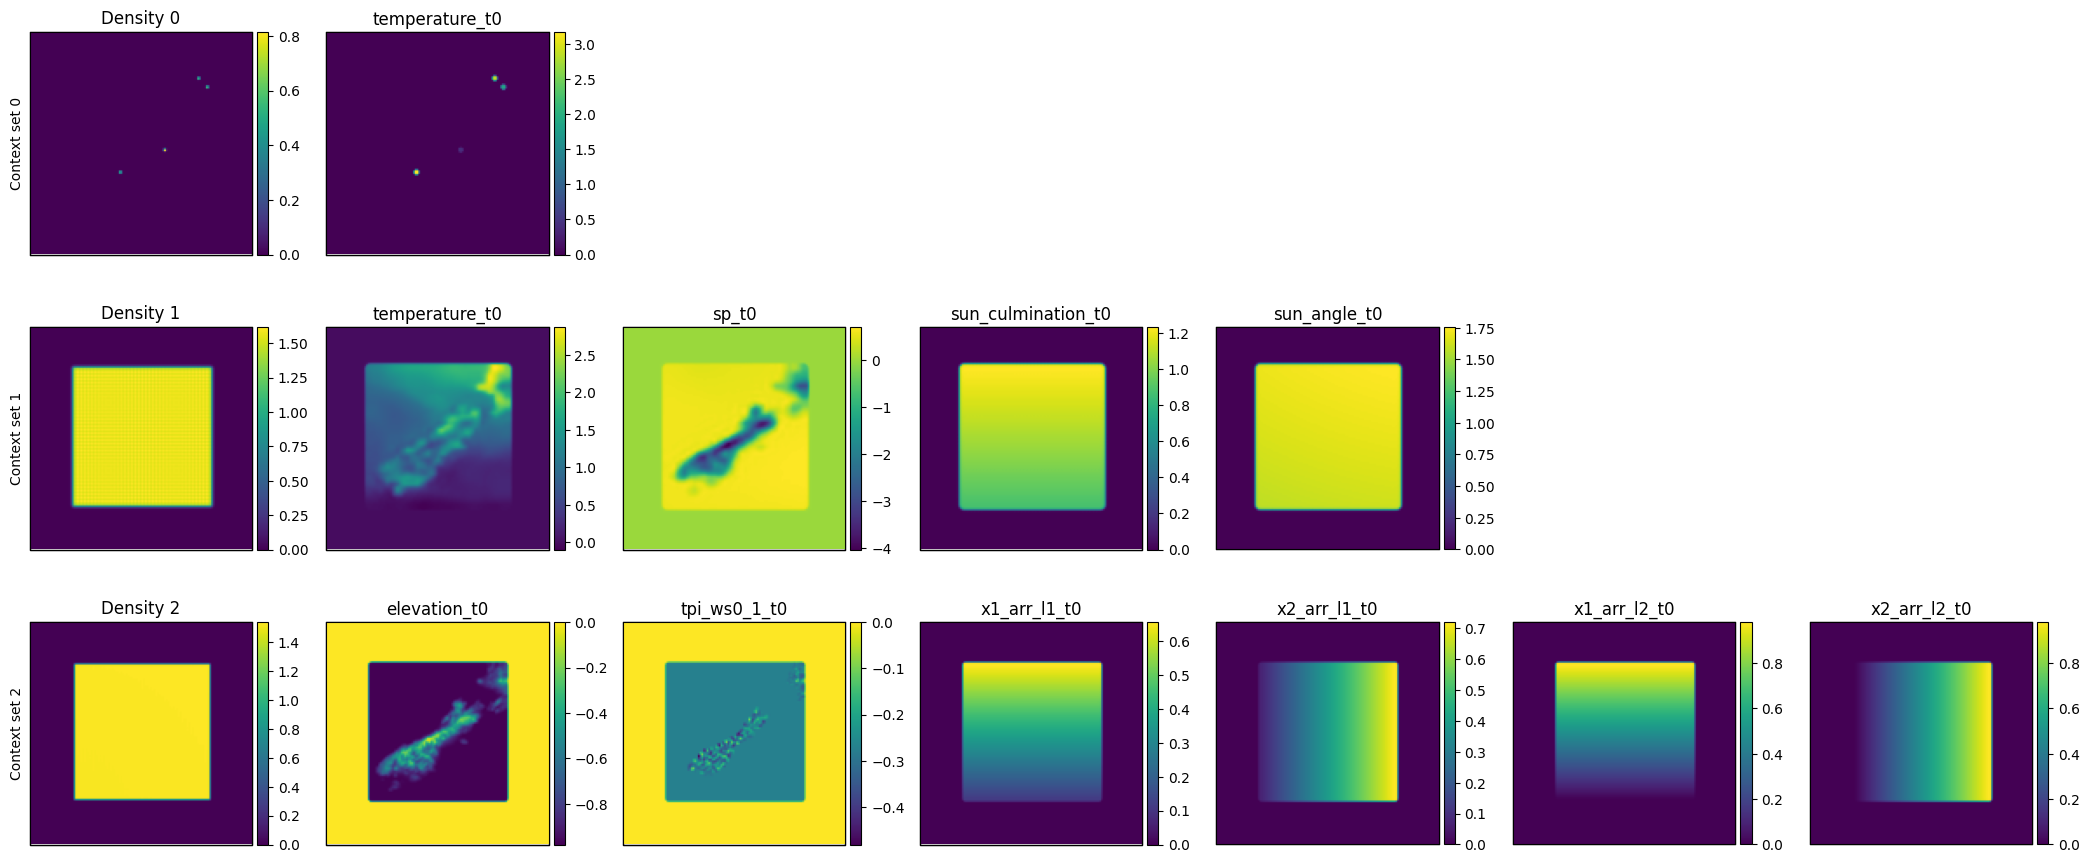

In [52]:
fig = deepsensor.plot.context_encoding(model, train_tasks[100], task_loader)

In [53]:
# training loop. Train baseline model for 50 epochs.
n_epochs = 10
lr=5e-5 * 2

val_loss_best = np.inf

opt = optim.Adam(model.model.parameters(), lr=lr)

for epoch in range(n_epochs):
    batch_losses = train_epoch(model, train_tasks_epoch)
    
    train_loss = np.mean(batch_losses)
    # write the train loss to tensorboard
    tb_writer.add_scalar(TB_TRAIN_LOSS, train_loss, epoch+1)
    tb_writer.add_scalar('GPU Memory Usage (MiB)', torch.cuda.max_memory_reserved()/1024**2, epoch+1)
    tb_writer.flush()

    # you could add early stopping or model checkpointing here

    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            val_loss = compute_val_loss(model, val_tasks_epoch)
            tb_writer.add_scalar(TB_VAL_LOSS, val_loss, epoch+1)
            tb_writer.flush()

        logger.info(f"Epoch {epoch+1} train_loss: {train_loss:.2f}, val_loss: {val_loss:.2f}")
    

2025-12-03 15:58:26 - INFO - __main__ - Epoch 5 train_loss: 1.31, val_loss: 1.30
2025-12-03 16:00:17 - INFO - __main__ - Epoch 10 train_loss: 1.31, val_loss: 1.29


There are multiple applications for adding in new layers after transfer learning:
- localised datasets like rain radar, NZ refined assimilations
- smaller x1x2 grid layers for high-resolution dependencies on smaller training spaces

